In [1]:
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
df_train = pd.read_parquet('./data/fhv_tripdata_2021-01.parquet')
df_val = pd.read_parquet('./data/fhv_tripdata_2021-02.parquet')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154112 entries, 0 to 1154111
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1154112 non-null  object        
 1   pickup_datetime         1154112 non-null  datetime64[ns]
 2   dropOff_datetime        1154112 non-null  datetime64[ns]
 3   PUlocationID            195845 non-null   float64       
 4   DOlocationID            991892 non-null   float64       
 5   SR_Flag                 0 non-null        object        
 6   Affiliated_base_number  1153227 non-null  object        
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 61.6+ MB


In [4]:
df_train.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


In [5]:
df_train.isna().sum()/df_train.shape[0]

dispatching_base_num      0.000000
pickup_datetime           0.000000
dropOff_datetime          0.000000
PUlocationID              0.830307
DOlocationID              0.140558
SR_Flag                   1.000000
Affiliated_base_number    0.000767
dtype: float64

# Q1. Downloading the data

In [6]:
df_train.shape

(1154112, 7)

# Q2. Computing duration

In [7]:
df_train['duration'] = df_train.dropOff_datetime - df_train.pickup_datetime
df_train.duration = df_train.duration.apply(lambda td: td.total_seconds() / 60)

categorical = ['PUlocationID', 'DOlocationID']
df_train[categorical] = df_train[categorical].astype(str)

In [8]:
df_train.duration.mean()

19.167224093791006

<AxesSubplot:>

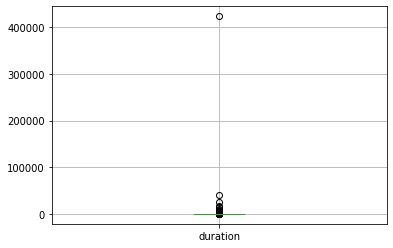

In [9]:
df_train.boxplot(column=['duration'])

In [10]:
df_train = df_train[(df_train.duration >= 1) & (df_train.duration <= 60)]

# Q3. Missing values

In [11]:
df_train[['PUlocationID', 'DOlocationID']] = df_train[['PUlocationID', 'DOlocationID']].replace({'nan': '-1'})

In [12]:
(df_train.PUlocationID == '-1').sum()/df_train.PUlocationID.size

0.8352732770722617

# Q4. One-hot encoding

In [13]:
train_dicts = df_train[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df_train[target].values

In [14]:
X_train.shape

(1109826, 525)

In [15]:
X_train.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [16]:
y_train.shape

(1109826,)

# Q5. Training a model

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

10.528519432127307

# Q6. Evaluating the model

In [18]:
def prepare_data(df_in, dv):
    df = df_in.copy()
    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    categorical = ['PUlocationID', 'DOlocationID']
    df[categorical] = df[categorical].astype(str)
    
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    df.loc[:, ['PUlocationID', 'DOlocationID']] = df[['PUlocationID', 'DOlocationID']].replace({'nan': '-1'})
    return df

In [19]:
df_val = prepare_data(df_val, dv)

In [20]:
val_dicts = df_val[categorical].to_dict(orient='records')

X_val = dv.transform(val_dicts)

y_val = df_val[target].values

In [21]:
X_val.shape

(990113, 525)

In [22]:
y_val.shape

(990113,)

In [23]:
y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.01428567707267